This is needed to reload modules without restarting the kernel

In [185]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is needed to add eda_tools from the directories above

In [ ]:
import os
os.sys.path.append('../../')

# Analyzing Shap-ley values for the neural network output

Let's see if we can use the concept of SHAP values from Explainable AI to tell us which features of the network are most important to the reweighting.

In [ ]:
!ls -lh /mnt/storage/lborgna/NNT/

In [ ]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import  BatchNormalization


In [ ]:
import shap

In [9]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [10]:
f.keys()

[b'validation;1',
 b'control;1',
 b'sig;1',
 b'fullmassplane;1',
 b'NN_norm_bstrap_med_17;1',
 b'NN_norm_bstrap_IQR_17;1',
 b'NN_norm_bstrap_perc_25_17;1',
 b'NN_norm_bstrap_perc_75_17;1',
 b'NN_norm_VRderiv_bstrap_med_17;1',
 b'NN_norm_VRderiv_bstrap_IQR_17;1',
 b'NN_norm_VRderiv_bstrap_perc_25_17;1',
 b'NN_norm_VRderiv_bstrap_perc_75_17;1']

In [11]:
df_cr = f['control'].pandas.df()

In [12]:
df_cr.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'lead_jet_pT', 'lead_jet_tag', 'HT', 'm_hh_cor',
       'm_hh', 'pt_hh', 'dEta_hh', 'X_wt', 'X_wt_2', 'trig_bucket', 'm_h1',
       'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2',
       'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1',
       'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2',
       'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2',
       'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_bstrap_perc_25_17', 'NN_d24_weight_bstrap_perc_75

In [13]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [14]:
features_to_rw = nominal()

In [15]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [16]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.


In [17]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [18]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

In [19]:
train_size = df_cr.shape[0]

In [107]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [116]:
original

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  \
entry                                                                  
0        4.922156  4.094102  0.580108    0.077623    0.150979      6   
1        4.068959  3.933927  0.692013   -0.552564    0.324374      4   
2        4.276298  3.850584  0.894322    0.301334    1.091012      5   
3        5.381969  4.357126  0.983023   -0.239998    0.062671      5   
4        5.260033  4.285115  1.413674   -0.217042   -0.146484      5   
...           ...       ...       ...         ...         ...    ...   
1790768  4.833177  4.216176  1.268172    0.120126    0.466270      4   
1790769  4.190639  3.841277  0.666791   -0.682192    1.167135      4   
1790770  4.620880  4.014882  0.580534    0.299267    0.343568      4   
1790771  4.403122  3.976500  0.692854    0.250080    0.698023      5   
1790772  4.497886  4.019805  1.374716    0.421566    0.676250      4   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2  
entry                                                       
0         3.901757  1.254881  3.269802  0.712290  1.113665  
1         3.571677  0.877563  2.859212  2.735859  2.873533  
2         3.377382  0.464966  3.261541  1.211610  1.496300  
3         4.999299  1.146898  3.052898  0.657044  0.937919  
4         4.207677  1.200682  2.975830  0.743185  0.861584  
...            ...       ...       ...       ...       ...  
1790768   3.923227  1.564158  2.992440  1.376502  1.066973  
1790769   4.342710  0.960172  2.900200  2.019342  1.258126  
1790770   4.373713  1.459312  2.971416  0.959357  0.397834  
1790771   4.513000  1.284013  2.885606  1.011240  0.786170  
1790772   1.876268  1.342464  3.208356  1.508848  1.141601  

[1738549 rows x 11 columns]

In [108]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [109]:
X_all = pd.concat((original, target), ignore_index=True)
Y_all = create_labels(original, target)

In [110]:
Y_all = Y_all.astype('float32')

In [111]:
scaler = StandardScaler()

In [112]:
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [113]:
idx = np.random.permutation(X_train.shape[0])

In [114]:
X_train = X_train[idx]
Y_train = Y_train[idx]

In [115]:
X_train

array([[ 2.35155242, -0.21036953, -0.98685238, ...,  0.17173445,
        -1.12948406, -0.7825441 ],
       [-1.31253433, -0.52315136,  0.31008138, ..., -2.23120712,
         0.96110191,  1.19405255],
       [-0.69668197,  0.4198787 , -0.81510352, ...,  0.1869184 ,
         1.12214248,  1.07078556],
       ...,
       [-1.54968147, -0.99088487,  0.76051906, ..., -2.52224358,
         1.44150287,  1.3606308 ],
       [-0.73221119, -0.34751164, -0.7107731 , ...,  0.67722337,
        -1.19241239, -1.08474263],
       [-0.07190962,  0.77307222, -0.94381042, ...,  0.43610653,
        -0.55047435, -0.39830497]])

In [118]:
X

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  \
0        4.922156  4.094102  0.580108    0.077623    0.150979      6   
1        4.068959  3.933927  0.692013   -0.552564    0.324374      4   
2        4.276298  3.850584  0.894322    0.301334    1.091012      5   
3        5.381969  4.357126  0.983023   -0.239998    0.062671      5   
4        5.260033  4.285115  1.413674   -0.217042   -0.146484      5   
...           ...       ...       ...         ...         ...    ...   
1768319  4.403872  3.715313  0.843063    0.109908    0.661606      4   
1768320  4.675291  4.238040  0.717294    0.023256    0.614109      5   
1768321  5.191427  3.924209  0.971314   -0.596955   -0.134540      4   
1768322  4.343576  3.839129  0.672896   -0.321335    0.732488      5   
1768323  4.630334  4.285814  0.415552   -0.458062    0.341956      5   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2  
0         3.901757  1.254881  3.269802  0.712290  1.113665  
1         3.571677  0.877563  2.859212  2.735859  2.873533  
2         3.377382  0.464966  3.261541  1.211610  1.496300  
3         4.999299  1.146898  3.052898  0.657044  0.937919  
4         4.207677  1.200682  2.975830  0.743185  0.861584  
...            ...       ...       ...       ...       ...  
1768319   4.116948  0.999585  2.829177  1.020397  1.182970  
1768320   4.850877  1.556835  2.828631  1.010079  1.419067  
1768321   3.536753  1.669546  3.447720  0.531442  0.336206  
1768322   4.832779  0.527446  1.100964  1.607778  3.041889  
1768323   5.073459  1.123454  2.935041  0.132745  1.375552  

[1768324 rows x 11 columns]

In [124]:
X_train_2b = pd.DataFrame(scaler.transform(original), columns = features_to_rw['rw_cols_log'
])
X_train_4b = pd.DataFrame(scaler.transform(target), columns = features_to_rw['rw_cols_log'])

In [126]:
X_train_2b['class'] = '2-tag'
X_train_4b['class'] = '4-tag'

In [128]:
all_together = pd.concat([X_train_2b, X_train_4b], ignore_index=True)

In [130]:
import seaborn as sns

<AxesSubplot:>

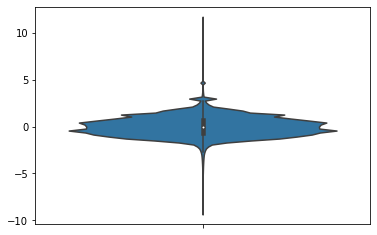

In [131]:
sns.violinplot(x=y=features_to_rw['rw_cols_log'], data=all_together, hue = 'class')

In [136]:
df_melt = all_together.drop(columns="class").melt(var_name='Column', value_name='Normalized Feature')

In [137]:
df_melt

Column  Normalized Feature
0         pT_2_log            0.956158
1         pT_2_log           -1.310945
2         pT_2_log           -0.760008
3         pT_2_log            2.177967
4         pT_2_log            1.853960
...            ...                 ...
19451559   dPhi_h2           -0.166123
19451560   dPhi_h2            0.100232
19451561   dPhi_h2           -1.121405
19451562   dPhi_h2            1.931029
19451563   dPhi_h2            0.051140

[19451564 rows x 2 columns]

<AxesSubplot:xlabel='Column', ylabel='Normalized Feature'>

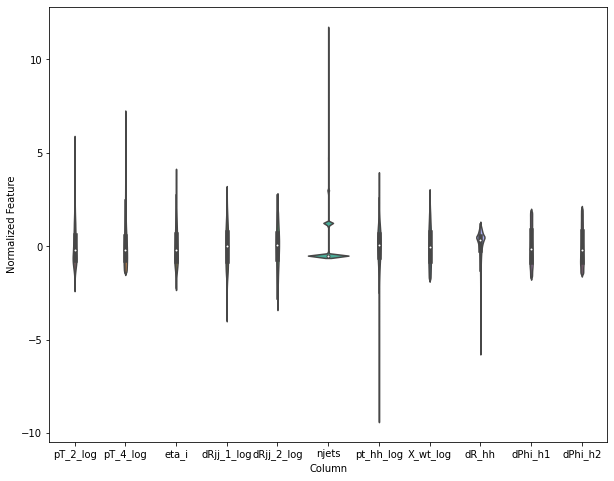

In [140]:
plt.subplots(figsize=(10, 8))
sns.violinplot(x='Column', y='Normalized Feature', data=df_melt)

In [129]:
all_together

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log     njets  \
0        0.956158  0.361689 -0.772098    0.561095   -0.653341  2.959181   
1       -1.310945 -0.342541 -0.481494   -1.211416   -0.218848 -0.509910   
2       -0.760008 -0.708969  0.043879    1.190323    1.702189  1.224636   
3        2.177967  1.518108  0.274225   -0.332268   -0.874623  1.224636   
4        1.853960  1.201504  1.392573   -0.267702   -1.398721  1.224636   
...           ...       ...       ...         ...         ...       ...   
1768319 -0.421019 -1.303705 -0.089234    0.651904    0.626185 -0.509910   
1768320  0.300191  0.994531 -0.415841    0.408178    0.507169  1.224636   
1768321  1.671661 -0.385266  0.243817   -1.336273   -1.368792 -0.509910   
1768322 -0.581238 -0.759332 -0.531138   -0.561043    0.803802  1.224636   
1768323  0.180732  1.204575 -1.199429   -0.945614   -0.174792  1.224636   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2  class  
0         0.229681  0.400692  0.787812 -0.861803 -0.244310  2-tag  
1        -0.186834 -0.567130 -0.023890  1.435358  1.741097  2-tag  
2        -0.432007 -1.625441  0.771481 -0.294973  0.187362  2-tag  
3         1.614627  0.123714  0.359011 -0.924518 -0.442579  2-tag  
4         0.615710  0.261671  0.206654 -0.826730 -0.528697  2-tag  
...            ...       ...       ...       ...       ...    ...  
1768319   0.501223 -0.254143 -0.083267 -0.512038 -0.166123  4-tag  
1768320   1.427339  1.175202 -0.084346 -0.523751  0.100232  4-tag  
1768321  -0.230903  1.464307  1.139543 -1.067101 -1.121405  4-tag  
1768322   1.404502 -1.465180 -3.499806  0.154758  1.931029  4-tag  
1768323   1.708207  0.063579  0.126017 -1.519703  0.051140  4-tag  

[1768324 rows x 12 columns]

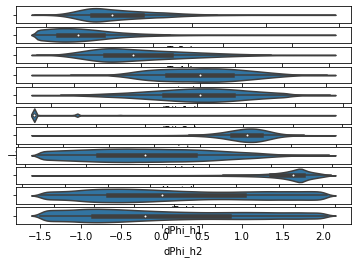

In [143]:
nf = len(features_to_rw['rw_cols_log'])
f, ax = plt.subplots(nf, 1)
for i, feature in enumerate(features_to_rw['rw_cols_log']):
    sns.violinplot(x=feature, hue='class', data=all_together, ax = ax[i])

In [147]:
all_together

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log     njets  \
0        0.956158  0.361689 -0.772098    0.561095   -0.653341  2.959181   
1       -1.310945 -0.342541 -0.481494   -1.211416   -0.218848 -0.509910   
2       -0.760008 -0.708969  0.043879    1.190323    1.702189  1.224636   
3        2.177967  1.518108  0.274225   -0.332268   -0.874623  1.224636   
4        1.853960  1.201504  1.392573   -0.267702   -1.398721  1.224636   
...           ...       ...       ...         ...         ...       ...   
1768319 -0.421019 -1.303705 -0.089234    0.651904    0.626185 -0.509910   
1768320  0.300191  0.994531 -0.415841    0.408178    0.507169  1.224636   
1768321  1.671661 -0.385266  0.243817   -1.336273   -1.368792 -0.509910   
1768322 -0.581238 -0.759332 -0.531138   -0.561043    0.803802  1.224636   
1768323  0.180732  1.204575 -1.199429   -0.945614   -0.174792  1.224636   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2  class  
0         0.229681  0.400692  0.787812 -0.861803 -0.244310  2-tag  
1        -0.186834 -0.567130 -0.023890  1.435358  1.741097  2-tag  
2        -0.432007 -1.625441  0.771481 -0.294973  0.187362  2-tag  
3         1.614627  0.123714  0.359011 -0.924518 -0.442579  2-tag  
4         0.615710  0.261671  0.206654 -0.826730 -0.528697  2-tag  
...            ...       ...       ...       ...       ...    ...  
1768319   0.501223 -0.254143 -0.083267 -0.512038 -0.166123  4-tag  
1768320   1.427339  1.175202 -0.084346 -0.523751  0.100232  4-tag  
1768321  -0.230903  1.464307  1.139543 -1.067101 -1.121405  4-tag  
1768322   1.404502 -1.465180 -3.499806  0.154758  1.931029  4-tag  
1768323   1.708207  0.063579  0.126017 -1.519703  0.051140  4-tag  

[1768324 rows x 12 columns]

In [175]:
format_map = {"pT_2_log":"{:.3f}","njets":"{:.3f}"}


In [179]:
pd.__version__

'1.1.1'

In [181]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [184]:
all_together[['pT_2_log','pT_4_log','eta_i','dRjj_1_log','dRjj_2_log','njets']].describe([0.01,0.25, 0.75, 0.99])

pT_2_log    pT_4_log       eta_i  dRjj_1_log  dRjj_2_log       njets
count 1768324.000 1768324.000 1768324.000 1768324.000 1768324.000 1768324.000
mean       -0.000       0.000      -0.000       0.000       0.000      -0.000
std         1.000       1.000       1.000       1.000       1.000       1.000
min        -2.285      -1.420      -2.225      -3.897      -3.297      -0.510
1%         -1.650      -1.388      -1.679      -1.945      -2.338      -0.510
25%        -0.748      -0.756      -0.763      -0.787      -0.682      -0.510
50%        -0.195      -0.177      -0.170      -0.008       0.049      -0.510
75%         0.616       0.538       0.650       0.749       0.728      -0.510
99%         2.837       3.102       2.604       2.131       1.940       2.959
max         5.792       7.150       4.034       3.110       2.728      11.632

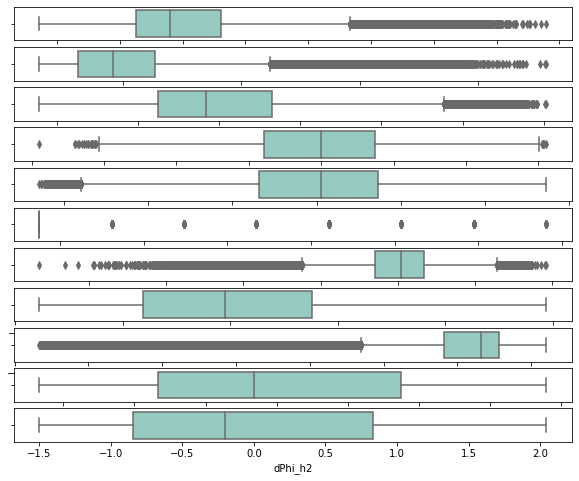

In [148]:
nf = len(features_to_rw['rw_cols_log'])
f, ax = plt.subplots(nf, 1, figsize= (10, 8))
for i, feature in enumerate(features_to_rw['rw_cols_log']):
    sns.boxplot(x=feature, hue='class', data=all_together, ax = ax[i], palette="Set3")

In [154]:
X_train_2b['njets'].value_counts()

-0.509910     1327497
 1.224636      339335
 2.959181       60447
 4.693727        9559
 6.428273        1446
 8.162818         233
 9.897364          24
 11.631910          8
Name: njets, dtype: int64

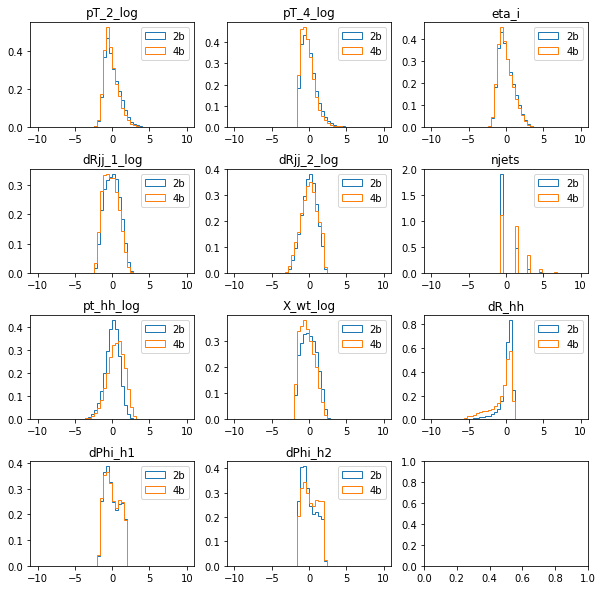

In [162]:
nf = len(features_to_rw['rw_cols_log'])
f, ax = plt.subplots(4, 3, figsize= (10, 10))
ax=ax.ravel()
be = np.linspace(-10, 10, 51)
for i, feature in enumerate(features_to_rw['rw_cols_log']):
    _= ax[i].hist(X_train_2b[feature].values, bins = be,histtype='step',label = '2b',density=True)
    _ =ax[i].hist(X_train_4b[feature].values, bins = be, histtype='step', label = '4b', density=True)
    ax[i].set_title(feature)
    ax[i].legend()
plt.subplots_adjust(hspace=0.4)

In [28]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_train.shape[1]),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [29]:
import tensorflow.keras.backend as K

In [30]:
def louppe_loss_tf2(y_true, y_pred):
    return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [31]:
model.compile(loss=louppe_loss_tf2, metrics = ['accuracy'], optimizer='adam')

In [32]:
history = model.fit(X_train, Y_train,
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=True),
                            ModelCheckpoint('model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                            epochs=500,
                            validation_split = 0.4,
                            batch_size=8192,
                   )

Train on 1060994 samples, validate on 707330 samples
Epoch 1/500
 983040/1060994 [==========================>...] - ETA: 0s - loss: 0.3201 - accuracy: 0.0168
Epoch 00001: val_loss improved from inf to 0.24505, saving model to model.h5
1060994/1060994 [==============================] - 3s 3us/sample - loss: 0.3142 - accuracy: 0.0168 - val_loss: 0.2451 - val_accuracy: 0.0169
Epoch 2/500
1024000/1060994 [===========================>..] - ETA: 0s - loss: 0.2410 - accuracy: 0.0168
Epoch 00002: val_loss improved from 0.24505 to 0.23834, saving model to model.h5
1060994/1060994 [==============================] - 1s 1us/sample - loss: 0.2409 - accuracy: 0.0168 - val_loss: 0.2383 - val_accuracy: 0.0169
Epoch 3/500
1032192/1060994 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.0168
Epoch 00003: val_loss improved from 0.23834 to 0.23580, saving model to model.h5
1060994/1060994 [==============================] - 1s 1us/sample - loss: 0.2365 - accuracy: 0.0168 - val_loss: 

In [33]:
model.load_weights('model.h5')

In [34]:
Y_train==0

array([False, False, False, ..., False, False, False])

In [42]:
X_val = X_train[-5000:]

In [43]:
X_val.shape

(5000, 11)

In [44]:
e = shap.DeepExplainer(model, X_val)

In [45]:
X_train[39]

array([ 1.98374949, -1.15840074, -1.18299126,  0.83849613,  0.39735793,
       -0.50991007,  0.42417886, -0.38823591,  0.17218789, -0.37609768,
        0.37303768])

In [46]:
shap_values = e.shap_values(X_val)

In [47]:
X_train.shape

(1768324, 11)

In [48]:
len(features_to_rw['rw_cols_log'])

11

In [49]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f492bd05080>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :

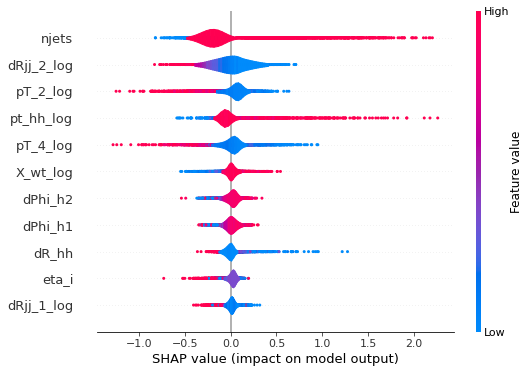

In [50]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="violin"
)

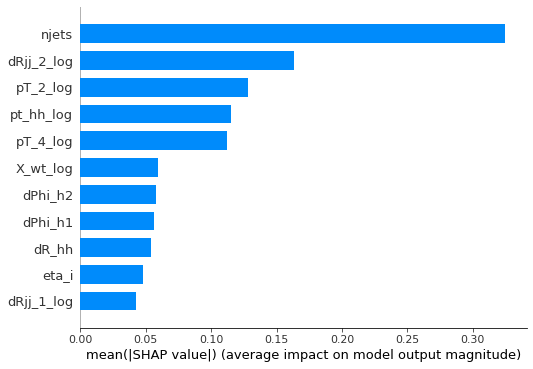

In [51]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="bar"
)

In [73]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [76]:
plt.gcf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.

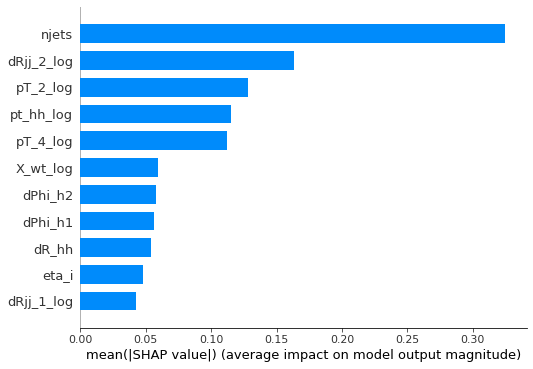

In [80]:
f = shap.summary_plot(
    shap_values[0],
    X_val,
    feature_names=features_to_rw["rw_cols_log"],
    plot_type="bar",
    show=False,
)

In [81]:
plt.savefig("test.pdf")

<Figure size 432x288 with 0 Axes>

![](test.png)

is the model fucked?

In [122]:
df_cr_2b = df_cr.loc[df_cr['ntag']==2]

In [123]:
pred = model.predict(scaler.transform(df_cr_2b[features_to_rw['rw_cols_log']].values), batch_size=8192)

In [124]:
df_cr_2b['NN_weight'] = np.exp(pred)[:,0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
df_cr

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

         NN_d24_weight_VRderiv_bstrap_IQR_17   dPhi_h1   dPhi_h2     dR_hh  \
entry                                                                        
0                                   0.006992  0.712290  1.113665  3.269802   
1                                   0.003047  2.735859  2.873533  2.859212   
2                                   0.005574  1.211610  1.496300  3.261541   
3                                   0.003287  0.657044  0.937919  3.052898   
4                                   0.002947  0.743185  0.861584  2.975830   
...                                      ...       ...       ...       ...   
1790768                             0.002155  1.376502  1.066973  2.992440   
1790769                             0.002147  2.019342  1.258126  2.900200   
1790770                             0.001740  0.959357  0.397834  2.971416   
1790771                             0.010816  1.011240  0.786170  2.885606   
1790772                             0.002877  1.508848  1.141601  3.208356   

         pT_2_log  pT_4_log  dRjj_1_log  dRjj_2_log  pt_hh_log  X_wt_log  
entry                                                                     
0        4.922156  4.094102    0.077623    0.150979   3.901757  1.254881  
1        4.068959  3.933927   -0.552564    0.324374   3.571677  0.877563  
2        4.276298  3.850584    0.301334    1.091012   3.377382  0.464966  
3        5.381969  4.357126   -0.239998    0.062671   4.999299  1.146898  
4        5.260033  4.285115   -0.217042   -0.146484   4.207677  1.200682  
...           ...       ...         ...         ...        ...       ...  
1790768  4.833177  4.216176    0.120126    0.466270   3.923227  1.564158  
1790769  4.190639  3.841277   -0.682192    1.167135   4.342710  0.960172  
1790770  4.620880  4.014882    0.299267    0.343568   4.373713  1.459312  
1790771  4.403122  3.976500    0.250080    0.698023   4.513000  1.284013  
1790772  4.497886  4.019805    0.421566    0.676250   1.876268  1.342464  

[1790773 rows x 84 columns]

In [126]:
df_cr_2b

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

          dPhi_h1   dPhi_h2     dR_hh  pT_2_log  pT_4_log  dRjj_1_log  \
entry                                                                   
0        0.712290  1.113665  3.269802  4.922156  4.094102    0.077623   
1        2.735859  2.873533  2.859212  4.068959  3.933927   -0.552564   
2        1.211610  1.496300  3.261541  4.276298  3.850584    0.301334   
3        0.657044  0.937919  3.052898  5.381969  4.357126   -0.239998   
4        0.743185  0.861584  2.975830  5.260033  4.285115   -0.217042   
...           ...       ...       ...       ...       ...         ...   
1790768  1.376502  1.066973  2.992440  4.833177  4.216176    0.120126   
1790769  2.019342  1.258126  2.900200  4.190639  3.841277   -0.682192   
1790770  0.959357  0.397834  2.971416  4.620880  4.014882    0.299267   
1790771  1.011240  0.786170  2.885606  4.403122  3.976500    0.250080   
1790772  1.508848  1.141601  3.208356  4.497886  4.019805    0.421566   

         dRjj_2_log  pt_hh_log  X_wt_log  NN_weight  
entry                                                
0          0.150979   3.901757  1.254881   0.021189  
1          0.324374   3.571677  0.877563   0.016169  
2          1.091012   3.377382  0.464966   0.015380  
3          0.062671   4.999299  1.146898   0.008109  
4         -0.146484   4.207677  1.200682   0.006014  
...             ...        ...       ...        ...  
1790768    0.466270   3.923227  1.564158   0.007021  
1790769    1.167135   4.342710  0.960172   0.007283  
1790770    0.343568   4.373713  1.459312   0.009779  
1790771    0.698023   4.513000  1.284013   0.034945  
1790772    0.676250   1.876268  1.342464   0.009625  

[1738549 rows x 85 columns]

In [127]:
df_cr = df_cr.merge(
    df_cr_2b[["event_number", "run_number", "NN_weight"]],
    how="left",
    on=["event_number", "run_number"],
)

In [129]:
df_cr['NN_weight'].isna().value_counts()

False    1738549
True       52224
Name: NN_weight, dtype: int64

In [130]:
df_cr.fillna({'NN_weight':1}, inplace = True)

In [133]:
from eda_tools.utilities import getNorm

In [136]:
help(getNorm)

Help on function getNorm in module eda_tools.utilities:

getNorm(df, k, verbose=False, weight_column=None)
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    - verbose: Prints out the value of 4b, 2b and ratio. Return type includes 4b and 2b values



In [138]:
muQCD = getNorm(df_cr, k=2, weight_column='NN_weight')

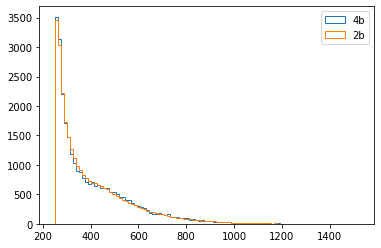

In [141]:
_,be,_ =plt.hist(df_cr.loc[df_cr.ntag>=4,'m_hh_cor'].values,
                bins = 100,
                histtype='step',
                label = '4b'
               )
_,_,_ = plt.hist(df_cr.loc[df_cr.ntag==2,'m_hh_cor'].values,
                bins = be, 
                histtype='step',
                label = '2b',
                weights=muQCD * df_cr.loc[df_cr.ntag==2,'NN_weight'].values
                )
plt.legend()

model seems to work just fine.

# Debug Ideas

save model summary to file

In [87]:
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)
        
model.summary(print_fn=myprint)

In [84]:
model.summary(print_fn=myprint)

In [88]:
!cat modelsummary.txt

_________________________________________________________________


In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [89]:
from contextlib import redirect_stdout

with open('modelsummary2.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [90]:
!cat modelsummary2.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [91]:
with open('modelsummary3.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [92]:
!cat modelsummary3.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [95]:
len(features_to_rw["rw_cols_log"])

11